# QMSS5074GR - Final Project (3rd)


**Group ID:** GR_2

**UNI:** am6490, cj2831, hk3354

**Full name:** Arsh Misra, Conor Jones, Flora Kwon

**Link to Public Github repository with Final report:**
https://github.com/hyerhinkwon/QMSS5074-Adv-ML.git

In [27]:
# Install dependencies
#pip install pandas bs4 nltk tensorflow scikit-learn matplotlib seaborn flask wordcloud torch xgboost transformers tf-keras googletrans

In [2]:
# Enable GPU
import torch
import tensorflow as tf

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using PyTorch device: {torch_device}")

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
else:
    print("TensorFlow is using CPU")


2025-05-13 04:50:17.967047: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 04:50:17.980771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747126217.995243 3495793 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747126218.000020 3495793 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747126218.013542 3495793 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using PyTorch device: cuda
TensorFlow is using GPU


In [3]:
import gc

def empty():
    torch.cuda.empty_cache()
    gc.collect()

empty()

## Part 1 – Data Ingestion & Preprocessing


1. **Data Loading**  
    - Acquire the Stanford Sentiment Treebank dataset.
    - Split into training, validation, and test sets with stratified sampling to preserve class balance.
    - Clearly document your splitting strategy and resulting dataset sizes.
    

In [29]:
# IMPORT DATA
!git clone https://github.com/YJiangcm/SST-2-sentiment-analysis.git

fatal: destination path 'SST-2-sentiment-analysis' already exists and is not an empty directory.


In [4]:
from pathlib import Path
import pandas as pd

data_dir = Path("SST-2-sentiment-analysis")

csv_tsv = [fp for fp in data_dir.rglob('*')
           if fp.is_file() and fp.suffix.lower() in ('.csv', '.tsv')]

for f in csv_tsv:
    print(f)

SST-2-sentiment-analysis/data/train.tsv
SST-2-sentiment-analysis/data/dev.tsv
SST-2-sentiment-analysis/data/test.tsv


It appears that the only available dataset are those already split into train/test/val sets. We'll retain the original split for ease.

Based on research, we have found the metadata of the original dataset.

The sentences in the Stanford Sentiment Treebank were split into a
train (8544), dev (1101) and test splits (2210). Then the dataset was filtered for only positive and negative sentences, ignoring the neutral class. This removed 20% of the data, with the final three sets having 6920/872/1821 sentences.

**Reference:** *Socher, R., Perelygin, A., Wu, J., Chuang, J., Manning, C., Ng, A., & Potts, C. (2013). Parsing with compositional vector grammars. In Proceedings of the 2013 Conference on Empirical Methods in Natural Language Processing (EMNLP).*

In [3]:
df_train = pd.read_csv(csv_tsv[0], sep='\t')
df_train.head()

,1,"a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films"
0,0,apparently reassembled from the cutting-room f...
1,0,they presume their audience wo n't sit still f...
2,1,this is a visually stunning rumination on love...
3,1,jonathan parker 's bartleby should have been t...
4,1,campanella gets the tone just right -- funny i...


In [5]:
# Index 0 contains data. Reload appropriately using pipeline.
def load_correctly(filepath):
    df = pd.read_csv(filepath, sep='\t', header=None)
    df.columns = ['label', 'review']
    return df

In [6]:
df_train = load_correctly(csv_tsv[0])
df_train.head()

,label,review
0,1,"a stirring , funny and finally transporting re..."
1,0,apparently reassembled from the cutting-room f...
2,0,they presume their audience wo n't sit still f...
3,1,this is a visually stunning rumination on love...
4,1,jonathan parker 's bartleby should have been t...


In [7]:
df_test = load_correctly(csv_tsv[1])
df_test.head()

,label,review
0,0,one long string of cliches .
1,0,if you 've ever entertained the notion of doin...
2,0,k-19 exploits our substantial collective fear ...
3,0,it 's played in the most straight-faced fashio...
4,1,"there is a fabric of complex ideas here , and ..."


In [8]:
df_val = load_correctly(csv_tsv[2])
df_val.head()

,label,review
0,0,"no movement , no yuks , not much of anything ."
1,0,"a gob of drivel so sickly sweet , even the eag..."
2,0,"gangs of new york is an unapologetic mess , wh..."
3,0,"we never really feel involved with the story ,..."
4,1,this is one of polanski 's best films .



2. **Text Cleaning & Tokenization**  
    - Implement a reusable preprocessing pipeline that handles at least:  
        - HTML removal, lowercasing, punctuation stripping  
        - Vocabulary pruning (e.g., rare words threshold)  
        - Tokenization (character- or word-level)  
    - Expose this as a function/class so it can be saved and re-loaded for inference.
    

In [9]:
import re
import string
from bs4 import BeautifulSoup
from collections import Counter
import pickle
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

class TextCleaner:
    def __init__(self, min_freq=5, level='word', stop_words=None):
        self.min_freq = min_freq
        self.level = level  # 'word' or 'char'
        self.vocab = set()
        if stop_words is None and self.level == 'word':
            self.stop_words = set(stopwords.words('english'))
        else:
            self.stop_words = set(stop_words) if stop_words else set()

    def clean_text(self, text):
        # Remove HTML
        text = BeautifulSoup(text, "html.parser").get_text()
        # Lowercase
        text = text.lower()
        # Remove punctuation *except* apostrophes
        punctuation = string.punctuation.replace("'", "").replace("’", "")
        text = text.translate(str.maketrans('', '', punctuation))
        return text
    
    def tokenize(self, text):
        if self.level == 'word':
            # Using re.findall with a modified regex to handle apostrophes
            return re.findall(r"\b\w+(?:['’]\w+)*|\w+\b", text)
        elif self.level == 'char':
            return list(text)
        else:
            raise ValueError("Tokenization level must be 'word' or 'char'.")

    def fit(self, texts):
        cleaned = [self.clean_text(t) for t in texts]
        tokenized = [self.tokenize(t) for t in cleaned]
        if self.level == 'word' and self.stop_words:
            tokenized = [[token for token in tokens if token not in self.stop_words] for tokens in tokenized]
        flat_tokens = [token for sublist in tokenized for token in sublist]
        freq = Counter(flat_tokens)
        self.vocab = {word for word, count in freq.items() if count >= self.min_freq}

    def transform(self, texts):
        cleaned = [self.clean_text(t) for t in texts]
        tokenized = [self.tokenize(t) for t in cleaned]
        if self.level == 'word' and self.stop_words:
            tokenized = [[token for token in tokens if token not in self.stop_words] for tokens in tokenized]
        pruned = [[token for token in tokens if token in self.vocab] for tokens in tokenized]

        return pruned

    def fit_transform(self, texts):
        self.fit(texts)
        return self.transform(texts)

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, 'rb') as f:
            return pickle.load(f)


[nltk_data] Downloading package stopwords to
[nltk_data]     /insomnia001/home/hk3354/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Instantiate the TextCleaner (using default settings)
cleaner = TextCleaner()

# Fit the cleaner to the training data
# (to build vocabulary based on word frequencies)
train_texts = df_train['review'].tolist() # Assuming 'review' column holds text
cleaner.fit(train_texts)

# Transform the DataFrames
df_train['cleaned_review'] = cleaner.transform(df_train['review'].tolist())
df_test['cleaned_review'] = cleaner.transform(df_test['review'].tolist())
df_val['cleaned_review'] = cleaner.transform(df_val['review'].tolist())

# Print the head of each DataFrame to inspect changes
print("df_train:")
print(df_train[['review', 'cleaned_review']].head())  # Print original and cleaned
print("\ndf_test:")
print(df_test[['review', 'cleaned_review']].head())  # Print original and cleaned
print("\ndf_val:")
print(df_val[['review', 'cleaned_review']].head())  # Print original and cleaned

df_train:
                                              review  \
0  a stirring , funny and finally transporting re...   
1  apparently reassembled from the cutting-room f...   
2  they presume their audience wo n't sit still f...   
3  this is a visually stunning rumination on love...   
4  jonathan parker 's bartleby should have been t...   

                                      cleaned_review  
0  [stirring, funny, finally, beauty, beast, horr...  
1                   [apparently, floor, given, soap]  
2  [audience, wo, n't, sit, still, lesson, howeve...  
3  [visually, stunning, love, memory, history, wa...  
4                                    [parker, films]  

df_test:
                                              review  \
0                       one long string of cliches .   
1  if you 've ever entertained the notion of doin...   
2  k-19 exploits our substantial collective fear ...   
3  it 's played in the most straight-faced fashio...   
4  there is a fabric of complex i


3. **Feature Extraction**  
    - **Traditional**: Build a TF-IDF vectorizer (or n-gram count) pipeline.  
    - **Neural**: Prepare sequences for embedding—pad/truncate to a fixed length.  
    - Save each preprocessor (vectorizer/tokenizer) to disk.
    

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# 1. Traditional Feature Extraction (TF-IDF)
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features

# Fit the vectorizer to the training data using cleaned_review
tfidf_vectorizer.fit(df_train['cleaned_review'].apply(lambda x: ' '.join(x)))  # Use cleaned_review column

# Transform the data using cleaned_review
X_train_tfidf = tfidf_vectorizer.transform(df_train['cleaned_review'].apply(lambda x: ' '.join(x)))
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_review'].apply(lambda x: ' '.join(x)))
X_val_tfidf = tfidf_vectorizer.transform(df_val['cleaned_review'].apply(lambda x: ' '.join(x)))

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# 2. Neural Feature Extraction (Embedding)
# Create a tokenizer
tokenizer = Tokenizer(num_words=5000)  # Limit to top 5000 words

# Fit the tokenizer to the training data using cleaned_review
tokenizer.fit_on_texts(df_train['cleaned_review'].apply(lambda x: ' '.join(x)))  # Use cleaned_review column

# Convert text to sequences using cleaned_review
sequences_train = tokenizer.texts_to_sequences(df_train['cleaned_review'].apply(lambda x: ' '.join(x)))
sequences_test = tokenizer.texts_to_sequences(df_test['cleaned_review'].apply(lambda x: ' '.join(x)))
sequences_val = tokenizer.texts_to_sequences(df_val['cleaned_review'].apply(lambda x: ' '.join(x)))

# Pad/truncate sequences to a fixed length
max_length = 100  # Adjust as needed
X_train_embed = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')
X_test_embed = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')
X_val_embed = pad_sequences(sequences_val, maxlen=max_length, padding='post', truncating='post')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Feature extraction completed and preprocessors saved.")

Feature extraction completed and preprocessors saved.


## Part 2 – Exploratory Data Analysis (EDA)


1. **Class Distribution**  
    - Visualize the number of positive vs. negative reviews.  
    - Compute descriptive statistics on review lengths (mean, median, IQR).
    

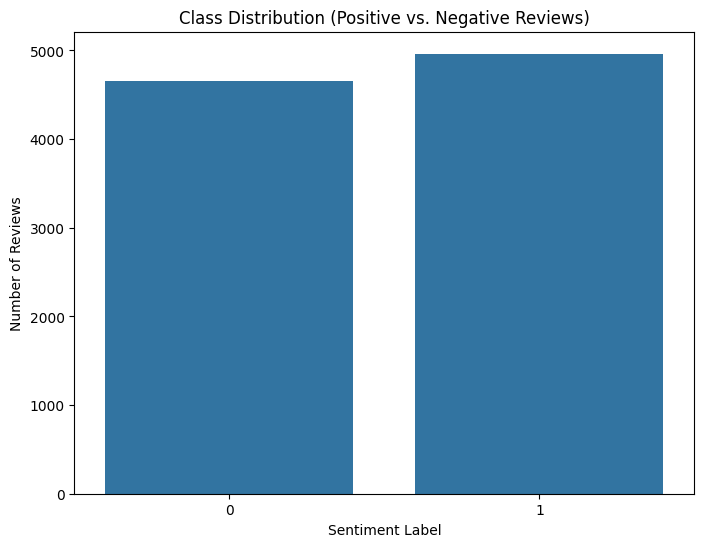

Descriptive Statistics on Review Lengths:
count    9613.000000
mean        6.776449
std         3.581269
min         0.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        23.000000
Name: review_length, dtype: float64

Interquartile Range (IQR): 5.0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualize Class Distribution
# Combine all datasets for overall distribution
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

# Count the number of positive and negative reviews
class_counts = df_all['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_all)
plt.title('Class Distribution (Positive vs. Negative Reviews)')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.show()

# 2. Compute Descriptive Statistics on Review Lengths
# Calculate review lengths using cleaned_review
df_all['review_length'] = df_all['cleaned_review'].apply(len)  # Changed to cleaned_review

# Compute descriptive statistics
review_length_stats = df_all['review_length'].describe()

# Calculate IQR
Q1 = review_length_stats['25%']
Q3 = review_length_stats['75%']
IQR = Q3 - Q1

# Print the statistics
print("Descriptive Statistics on Review Lengths:")
print(review_length_stats)
print("\nInterquartile Range (IQR):", IQR)

In [12]:
print(df_train['label'].unique())

[1 0]


In [13]:
print(df_train['label'].value_counts())

label
1    3610
0    3310
Name: count, dtype: int64


2. **Text Characteristics**  
   - Plot the 20 most frequent tokens per sentiment class.  
   - Generate word clouds (or bar charts) highlighting key terms for each class.  

Top 20 tokens for 0 Label
movie         100.940319
film           74.652367
like           61.345845
one            48.953040
bad            42.042256
much           38.004107
rrb            33.373951
even           33.123640
lrb            32.925411
story          32.588317
characters     29.896326
comedy         29.036019
would          27.202059
time           26.853452
nothing        26.697690
little         24.708094
never          24.493350
good           24.300273
really         23.295725
plot           23.173938
dtype: float64
Top 20 tokens for 1 Label
label           3610.000000
film             106.710813
movie             71.942080
one               54.058140
funny             41.224721
story             40.180358
like              37.165140
good              35.954103
best              33.569780
love              32.223151
comedy            31.701449
lrb               31.642027
rrb               31.615144
work              27.957636
fun               27.707241
performances 

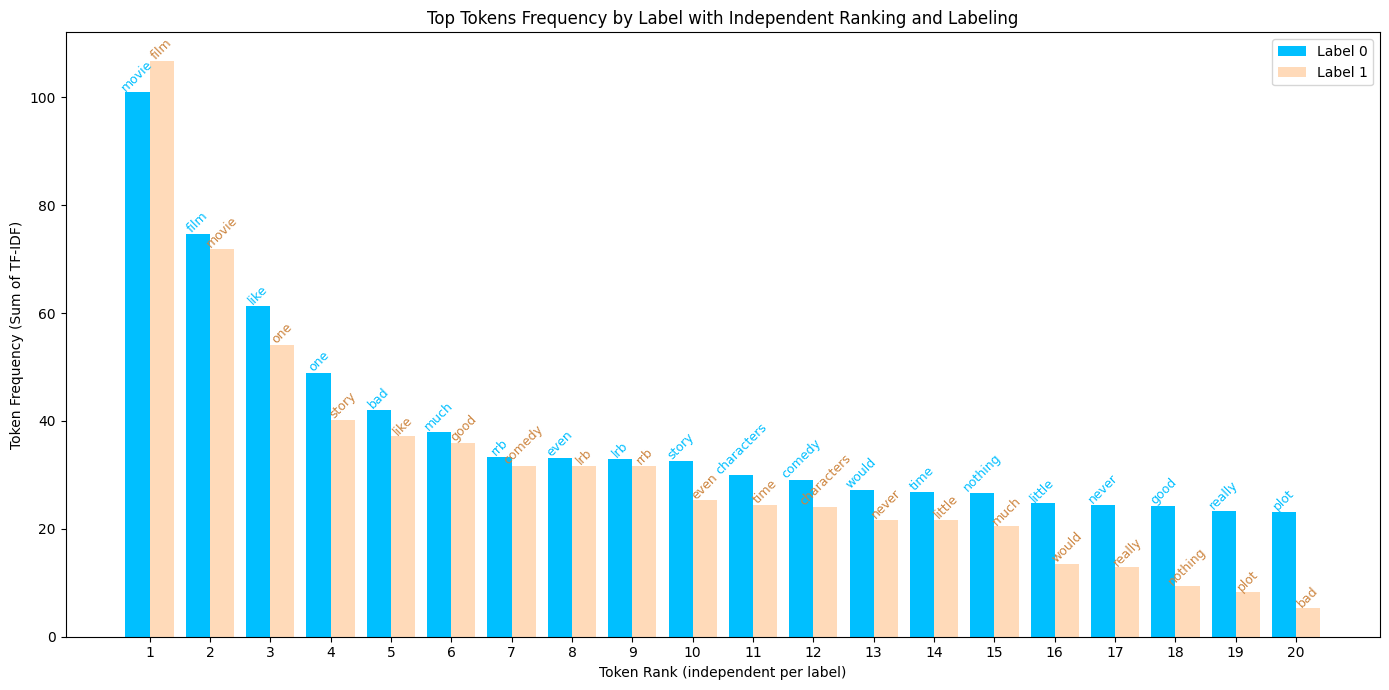

In [16]:
df_tfidf_X_train = pd.DataFrame(
    X_train_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)
#Apply the label
df_tfidf_X_train['label'] = df_train['label'].values

# Sum the TF-IDF values for each token across all documents
token_totals_0 = df_tfidf_X_train[df_tfidf_X_train['label'] == 0].sum(axis=0)

# Sort tokens by their total value in descending order and get the top 20
top_20_tokens_0 = token_totals_0.sort_values(ascending=False).head(20)

print("Top 20 tokens for 0 Label")
print(top_20_tokens_0)

# Sum the TF-IDF values for each token across all documents
token_totals_1 = df_tfidf_X_train[df_tfidf_X_train['label'] == 1].sum(axis=0)

# Sort tokens by their total value in descending order and get the top 20
top_20_tokens_1 = token_totals_1.sort_values(ascending=False).head(20)

print("Top 20 tokens for 1 Label")
print(top_20_tokens_1)

#Plotting these numbers:
# Sum TF-IDF values for each token per label
token_sums_label_0 = df_tfidf_X_train[df_tfidf_X_train['label'] == 0].drop('label', axis=1).sum(axis=0)
token_sums_label_1 = df_tfidf_X_train[df_tfidf_X_train['label'] == 1].drop('label', axis=1).sum(axis=0)

# Get the top 20 tokens by label 0 frequency
top_20_label_0 = token_sums_label_0.sort_values(ascending=False).head(20)
all_top_tokens = top_20_label_0.index

# Filter both label sums to include only these tokens
filtered_label_0 = token_sums_label_0[all_top_tokens]
filtered_label_1 = token_sums_label_1[all_top_tokens]

# Construct DataFrame for plotting
plot_df = pd.DataFrame({'label_0': filtered_label_0, 'label_1': filtered_label_1})

# Sort by label_0 for ranking
#plot_df_sorted = plot_df.sort_values(by='label_0', ascending=False)
#plot_df_sorted['rank'] = range(1, len(plot_df_sorted) + 1)

# Plot
#plt.figure(figsize=(12, 6))
#bar_width = 0.4
#x = plot_df_sorted['rank']

#plt.bar(x - bar_width/2, plot_df_sorted['label_0'], width=bar_width, label='Label 0')
#plt.bar(x + bar_width/2, plot_df_sorted['label_1'], width=bar_width, label='Label 1')

#plt.xlabel('Token Rank (by Label 0 frequency)')
#plt.ylabel('Token Frequency (Sum of TF-IDF)')
#plt.title('Top Tokens Frequency by Label')
#plt.xticks(ticks=x, labels=plot_df_sorted.index, rotation=45, ha='right')
#plt.legend()
#plt.tight_layout()
#plt.show()

#New plotting attempt:
# Example: Replace with your actual top 20 tokens and frequencies for each label
label_0_tokens = filtered_label_0.index.tolist()
label_0_values = filtered_label_0.values.tolist()
label_1_tokens = filtered_label_1.index.tolist()
label_1_values = filtered_label_1.values.tolist()

label_0_df = pd.DataFrame({'token': label_0_tokens, 'frequency': label_0_values}).sort_values(by='frequency', ascending=False).reset_index(drop=True)
label_1_df = pd.DataFrame({'token': label_1_tokens, 'frequency': label_1_values}).sort_values(by='frequency', ascending=False).reset_index(drop=True)
label_0_df['rank'] = label_0_df.index + 1
label_1_df['rank'] = label_1_df.index + 1

plt.figure(figsize=(14, 7))
bar_width = 0.4

# Plot bars for each label at their independent ranks
plt.bar(label_0_df['rank'] - bar_width/2, label_0_df['frequency'], width=bar_width, label='Label 0', color='deepskyblue')
plt.bar(label_1_df['rank'] + bar_width/2, label_1_df['frequency'], width=bar_width, label='Label 1', color='peachpuff')

# Set x-ticks to cover both ranks
all_ranks = sorted(set(label_0_df['rank']).union(set(label_1_df['rank'])))
plt.xticks(all_ranks)

# Annotate each bar with its token label
for i, row in label_0_df.iterrows():
    plt.text(row['rank'] - bar_width/2, row['frequency'] + 0.3, row['token'], ha='center', rotation=45, fontsize=9, color='deepskyblue')
for i, row in label_1_df.iterrows():
    plt.text(row['rank'] + bar_width/2, row['frequency'] + 0.3, row['token'], ha='center', rotation=45, fontsize=9, color='peru')

plt.xlabel('Token Rank (independent per label)')
plt.ylabel('Token Frequency (Sum of TF-IDF)')
plt.title('Top Tokens Frequency by Label with Independent Ranking and Labeling')
plt.legend()
plt.tight_layout()
plt.show()

#Big thing that this shows is that we need to get rid of the really common words in these.
  #I think this also explains why are model outcomes weren't super strong.

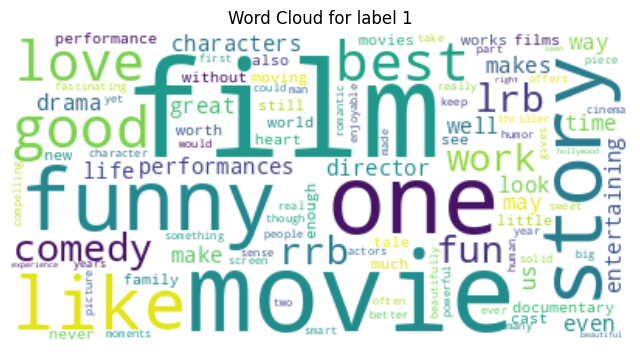

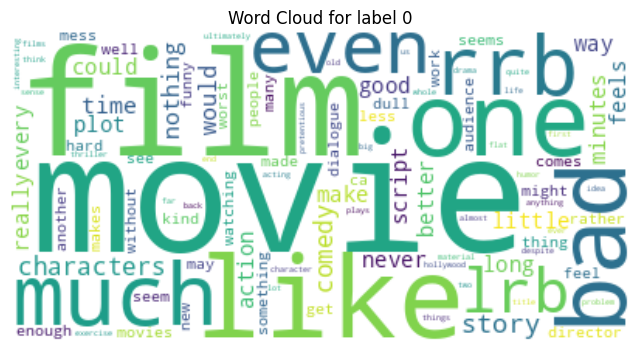

In [15]:
from wordcloud import WordCloud

labels = df_tfidf_X_train['label'].unique()

for label in labels:
    # Select only rows for the current label, drop the 'label' column
    group = df_tfidf_X_train[df_tfidf_X_train['label'] == label].drop('label', axis=1)
    # Sum TF-IDF scores for each word across all documents in the group
    freqs = group.sum(axis=0)

    # Check if all frequencies are zero
    if freqs.sum() == 0:
        print(f"Skipping word cloud for label {label} due to zero frequencies.")
        continue  # Skip to the next label

    # Convert to dictionary (word: score)
    freqs_dict = freqs.to_dict()

    # Generate the word cloud
    wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(freqs_dict)

    # Plot the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for label {label}')
    plt.show()


3. **Correlation Analysis**  
   - Analyze whether review length correlates with sentiment.  
   - Present findings numerically and with at least one visualization.

Printing correlation coefficient:
0.05333181734848405


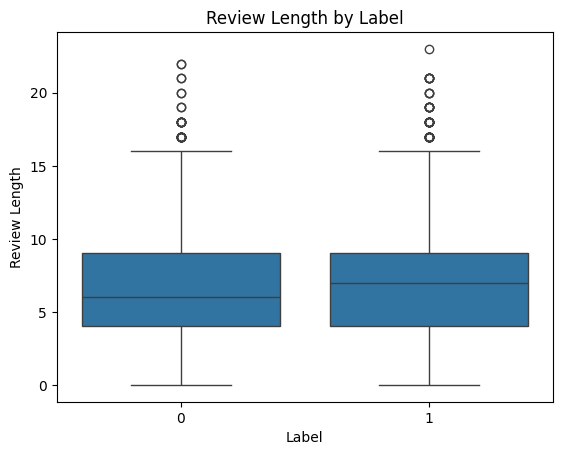

In [16]:
#Check whether review length correlates with sentiment:
#print(df_all.head())
#df_all = df_all[df_all['label'].isin([0, 1])]
correlation = df_all['review_length'].corr(df_all['label'].astype(float))
print("Printing correlation coefficient:")
print(correlation)

sns.boxplot(x='label', y='review_length', data=df_all)
plt.xlabel('Label')
plt.ylabel('Review Length')
plt.title('Review Length by Label')
plt.show()


## Part 3 – Baseline Traditional Models


1. **Logistic Regression & SVM**  
    - Train at least two linear models on your TF-IDF features.  
    - Use cross-validation (≥ 5 folds) on the training set to tune at least one hyperparameter.
    

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [18]:
def get_metrics(y_true, y_pred, model_name=None):
    metrics = {
        'F1-score': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred)
    }
    if model_name:
        print(f"\n{model_name} - Test Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")
    return metrics

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#Convert test tfidf into a dataframe

df_tfidf_X_test = pd.DataFrame(
    X_test_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)
#Apply the label
df_tfidf_X_test['label'] = df_test['label'].values

#Convert validation tfidf into a dataframe
df_tfidf_X_val = pd.DataFrame(
    X_val_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)
#Apply the label
df_tfidf_X_val['label'] = df_val['label'].values

def split_features_labels(df, split):
    X = df.drop(columns=[split])
    y = df[split]
    return X, y

X_train, y_train = split_features_labels(df_tfidf_X_train, "label")
X_test, y_test = split_features_labels(df_tfidf_X_test, "label")
X_val, y_val = split_features_labels(df_tfidf_X_val, "label")

# 2. Logistic Regression
param_grid_logreg = {'C': [0.1, 1, 10]}
logreg = LogisticRegression(max_iter=1000) # Increase max_iter if needed
cv_logreg = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified CV
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=cv_logreg, scoring='accuracy')
grid_search_logreg.fit(X_train, y_train)  # Changed to use y_train instead of df_train['label']

# Print and evaluate results
print("Logistic Regression - Best Parameters:", grid_search_logreg.best_params_)
print("Logistic Regression - Best Accuracy:", grid_search_logreg.best_score_)

y_pred_logreg = grid_search_logreg.predict(X_test)

# Add evaluation metrics
logreg_metrics = get_metrics(y_test, y_pred_logreg, model_name="Logistic Regression")
metrics_df = pd.DataFrame({'Logistic Regression': logreg_metrics}).T


Logistic Regression - Best Parameters: {'C': 1}
Logistic Regression - Best Accuracy: 0.7663294797687861

Logistic Regression - Test Metrics:
F1-score: 0.7684
Precision: 0.7599
Recall: 0.7770
ROC-AUC: 0.7612


In [20]:
del grid_search_logreg, y_pred_logreg
empty()

In [21]:
# 3. SVM
param_grid_svm = {'C': [0.1, 1, 10]}
svm = SVC()
cv_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified CV
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=cv_svm, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Print and evaluate results
print("\nSVM - Best Parameters:", grid_search_svm.best_params_)
print("SVM - Best Accuracy:", grid_search_svm.best_score_)

#y_pred_svm = grid_search_svm.predict(X_test_tfidf)
y_pred_svm = grid_search_svm.predict(X_test)
svm_metrics = get_metrics(y_test, y_pred_svm, model_name="SVM")
metrics_df.loc['SVM'] = svm_metrics


SVM - Best Parameters: {'C': 1}
SVM - Best Accuracy: 0.7670520231213873

SVM - Test Metrics:
F1-score: 0.7696
Precision: 0.7644
Recall: 0.7748
ROC-AUC: 0.7636


In [22]:
del y_pred_svm, grid_search_svm
empty()

2. **Random Forest & Gradient Boosting**  
   - Train two tree-based models (e.g., Random Forest, XGBoost) on the same features.  
   - Report feature-importance for each and discuss any notable tokens.

In [23]:
#Building Random Forest model
from sklearn.ensemble import RandomForestClassifier

# 1. Define and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_test_rf = rf_model.predict(X_test)

# 3. Predict on the validation set
y_pred_val_rf = rf_model.predict(X_val)

# 4. Define a function to print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, dataset_name):
    print(f"\nRandom Forest - {dataset_name} Metrics:")
    print(f"  ROC-AUC:  {roc_auc_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1-score:  {f1_score(y_true, y_pred):.4f}")

# 5. Evaluate on test and validation sets
print_evaluation_metrics(y_test, y_pred_test_rf, "Test")
print_evaluation_metrics(y_val, y_pred_val_rf, "Validation")

rf_metrics = get_metrics(y_test, y_pred_test_rf)
metrics_df.loc['Random Forest'] = rf_metrics


Random Forest - Test Metrics:
  ROC-AUC:  0.7249
  Precision: 0.7350
  Recall:    0.7185
  F1-score:  0.7267

Random Forest - Validation Metrics:
  ROC-AUC:  0.7249
  Precision: 0.7287
  Recall:    0.7151
  F1-score:  0.7218


In [24]:
#Get feature importance:
# Extract feature importances from the trained Random Forest model
feature_importances_rf = rf_model.feature_importances_
feature_names = X_train.columns

# Create a sorted list of tuples (feature, importance) in descending order
sorted_features = sorted(zip(feature_names, feature_importances_rf), key=lambda x: x[1], reverse=True)

# Display the top 20 features with their importance
top_20_features_rf = sorted_features[:20]
print("Now printing top 20 important features according to our RF model:")

Now printing top 20 important features according to our RF model:


In [26]:
del rf_model
empty()

/insomnia001/depts/edu/QMSS-GR5052/hk3354/ML/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:05:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/insomnia001/depts/edu/QMSS-GR5052/hk3354/ML/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:05:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/insomnia001/depts/edu/QMSS-GR5052/hk3354/ML/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:05:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn


Random Forest - Test Metrics:
  ROC-AUC:  0.6372
  Precision: 0.6051
  Recall:    0.8491
  F1-score:  0.7067

Random Forest - Validation Metrics:
  ROC-AUC:  0.6417
  Precision: 0.5994
  Recall:    0.8493
  F1-score:  0.7028
Now printing feature importance for XGEBoost:


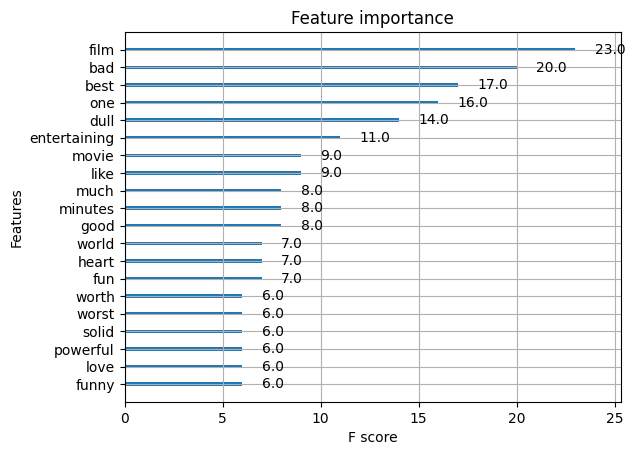

In [27]:
#Building the XGEBoost model
import xgboost as xgb

# 1. Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='binary:logistic',
    use_label_encoder=False,  # For newer versions of XGBoost
    eval_metric='logloss',
    random_state=42,
    tree_method='gpu_hist', 
    predictor='gpu_predictor'
)

# 2. Fit the model on the training data
xgb_model.fit(X_train, y_train)

# 3. Predict on test and validation sets
y_pred_test_xgb = xgb_model.predict(X_test)
y_pred_val_xgb = xgb_model.predict(X_val)

# 4. Evaluate on test and validation sets
print_evaluation_metrics(y_test, y_pred_test_xgb, "Test")
print_evaluation_metrics(y_val, y_pred_val_xgb, "Validation")
xgb_metrics = get_metrics(y_test, y_pred_test_xgb)
metrics_df.loc['XGEBoost'] = xgb_metrics

print("Now printing feature importance for XGEBoost:")
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()

In [28]:
del xgb_model
empty()

3. **Evaluation Metrics**  
   - Compute accuracy, precision, recall, F1-score, and ROC-AUC on the **held-out test set**.  
   - Present all results in a single comparison table.

In [29]:
print(metrics_df)

                     F1-score  Precision    Recall   ROC-AUC
Logistic Regression  0.768374   0.759912  0.777027  0.761177
SVM                  0.769575   0.764444  0.774775  0.763556
Random Forest        0.726651   0.735023  0.718468  0.724888
XGEBoost             0.706654   0.605136  0.849099  0.637166


## Part 4 – Neural Network Models


1. **Simple Feed-Forward**  
    - Build an embedding layer + a dense MLP classifier.  
    - Ensure you freeze vs. unfreeze embeddings in separate runs.
    

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

# 1. Simple Feed-Forward Neural Network with Freezing/Unfreezing

# --- Run 1: Freezing Embeddings ---
model_frozen = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100, trainable=False), # Freeze embeddings
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_frozen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_frozen.summary()

# Ensure y_train, X_train_embed, y_test, and X_test_embed have the same number of samples and are NumPy arrays
y_train = np.array(y_train)
X_train_embed = np.array(X_train_embed)
y_test = np.array(y_test)
X_test_embed = np.array(X_test_embed)

# Check for length mismatch and trim if necessary for training data
min_len_train = min(len(X_train_embed), len(y_train))
X_train_embed = X_train_embed[:min_len_train]
y_train = y_train[:min_len_train]

# Check and convert y_train data type
if y_train.dtype not in (np.int64, np.float64):
    y_train = y_train.astype(np.int64)  # or np.float64

# Check for length mismatch and trim if necessary for test data
min_len_test = min(len(X_test_embed), len(y_test))
X_test_embed = X_test_embed[:min_len_test]
y_test = y_test[:min_len_test]

# Check and convert y_test data type
if y_test.dtype not in (np.int64, np.float64):
    y_test = y_test.astype(np.int64)  # or np.float64

# Continue with model training for model_frozen:
history_frozen = model_frozen.fit(X_train_embed, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_test_embed, y_test))

# Evaluate model_frozen
loss_frozen, accuracy_frozen = model_frozen.evaluate(X_test_embed, y_test, verbose=0)
print(f"Frozen Model - Test Accuracy: {accuracy_frozen:.4f}")

# --- Run 2: Unfreezing Embeddings ---
model_unfrozen = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100, trainable=True), # Unfreeze embeddings
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_unfrozen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_unfrozen.summary()

# Continue with model training for model_unfrozen:
history_unfrozen = model_unfrozen.fit(X_train_embed, y_train,
                                      epochs=10,
                                      batch_size=32,
                                      validation_data=(X_test_embed, y_test))
# Evaluate model_unfrozen
loss_unfrozen, accuracy_unfrozen = model_unfrozen.evaluate(X_test_embed, y_test, verbose=0)
print(f"Unfrozen Model - Test Accuracy: {accuracy_unfrozen:.4f}")

/insomnia001/depts/edu/QMSS-GR5052/hk3354/ML/.venv/lib64/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1747119542.916564 3477923 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43550 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:0a:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1747119544.460999 3480144 service.cc:152] XLA service 0x14f668007c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747119544.461062 3480144 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-05-13 02:59:04.486186: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747119544.718835 3480144 cuda_dnn.cc:529] Loaded cuDNN version 90501


 29/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5198 - loss: 0.7124 

I0000 00:00:1747119545.003838 3480144 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5124 - loss: 0.7015 - val_accuracy: 0.5470 - val_loss: 0.6891
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5306 - loss: 0.6899 - val_accuracy: 0.5161 - val_loss: 0.6902
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5333 - loss: 0.6865 - val_accuracy: 0.6044 - val_loss: 0.6833
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5714 - loss: 0.6790 - val_accuracy: 0.5677 - val_loss: 0.6822
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5506 - loss: 0.6823 - val_accuracy: 0.5321 - val_loss: 0.6826
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5874 - loss: 0.6681 - val_accuracy: 0.5092 - val_loss: 0.7044
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5654 - loss: 0.6771 - val_accuracy: 0.5321 - val_loss: 0.6827
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5817 - loss: 0.6696 - val_accuracy: 0.4931 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5760 - loss: 0.6762 - val_accuracy: 0.7741 - val_loss: 0.5043
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8407 - loss: 0.3758 - val_accuracy: 0.7385 - val_loss: 0.5442
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9349 - loss: 0.1956 - val_accuracy: 0.7500 - val_loss: 0.6227
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9712 - loss: 0.0934 - val_accuracy: 0.7489 - val_loss: 0.7397
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0458 - val_accuracy: 0.7477 - val_loss: 0.8664
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9904 - loss: 0.0298 - val_accuracy: 0.7339 - val_loss: 1.0164
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9926 - loss: 0.0232 - val_accuracy: 0.7443 - val_loss: 1.0480
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9935 - loss: 0.0195 - val_accuracy: 0.

2. **Convolutional Text Classifier**  
   - Implement a 1D-CNN architecture (Conv + Pooling) for sequence data.  
   - Justify your choice of kernel sizes and number of filters.

In [25]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

#With 1D Convolutional Neural Network (CNN)

model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),  # Embedding layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Convolutional layer
    MaxPooling1D(pool_size=2),  # Max pooling layer
    Flatten(),  # Flatten for the dense layers
    Dense(64, activation='relu'),  # Dense hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

# Continue with model training for model_cnn:
history_cnn = model_cnn.fit(X_train_embed, y_train,
                              epochs=10,
                              batch_size=32,
                              validation_data=(X_test_embed, y_test))
# Evaluate model_cnn
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_embed, y_test, verbose=0)
print(f"CNN Model - Test Accuracy: {accuracy_cnn:.4f}")

/insomnia001/depts/edu/QMSS-GR5052/hk3354/ML/.venv/lib64/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5368 - loss: 0.6752 - val_accuracy: 0.7454 - val_loss: 0.5136
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8377 - loss: 0.3765 - val_accuracy: 0.7626 - val_loss: 0.5249
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9214 - loss: 0.2053 - val_accuracy: 0.7580 - val_loss: 0.6210
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9648 - loss: 0.1017 - val_accuracy: 0.7282 - val_loss: 0.8788
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9829 - loss: 0.0498 - val_accuracy: 0.7317 - val_loss: 1.1226
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9891 - loss: 0.0261 - val_accuracy: 0.7294 - val_loss: 1.3194
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9904 - loss: 0.0214 - val_accuracy: 0.7213 - val_loss: 1.4714
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9927 - loss: 0.0152 - val_accuracy: 0.

## Part 5 – Transfer Learning & Advanced Architectures


1. **Pre-trained Embeddings**  
    - Retrain one network using pre-trained GloVe (or FastText) embeddings.
    - Compare results against your from-scratch embedding runs.
    

In [26]:
""""!pip install --upgrade tensorflow
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip"""

# --- Run 1: Freezing Embeddings (from scratch) ---
model_frozen = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100, trainable=False), # Freeze embeddings
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_frozen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_frozen.summary()

# Continue with model training for model_frozen:
history_frozen = model_frozen.fit(X_train_embed, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_test_embed, y_test))
# Evaluate model_frozen
loss_frozen, accuracy_frozen = model_frozen.evaluate(X_test_embed, y_test, verbose=0)
print(f"Frozen Model (from scratch) - Test Accuracy: {accuracy_frozen:.4f}")

# --- Run 2: Using Pre-trained GloVe Embeddings ---

# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((5000, 100))  # Adjust vocabulary size if needed
for word, i in tokenizer.word_index.items():  # Assuming you have a 'tokenizer' object
    if i < 5000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model with GloVe embeddings
model_glove = Sequential([
    Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_glove.summary()

# Continue with model training for model_glove:
history_glove = model_glove.fit(X_train_embed, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_data=(X_test_embed, y_test))

# Evaluate model_glove
loss_glove, accuracy_glove = model_glove.evaluate(X_test_embed, y_test, verbose=0)
print(f"GloVe Model - Test Accuracy: {accuracy_glove:.4f}")

# Compare results
print("\nComparison of Test Accuracies:")
print(f"  Frozen Model (from scratch): {accuracy_frozen:.4f}")
print(f"  GloVe Model: {accuracy_glove:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5072 - loss: 0.6991 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5291 - loss: 0.6924 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5231 - loss: 0.6923 - val_accuracy: 0.5092 - val_loss: 0.6931
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5329 - loss: 0.6915 - val_accuracy: 0.5092 - val_loss: 0.6932
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5184 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6932
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5227 - loss: 0.6921 - val_accuracy: 0.5092 - val_loss: 0.6933
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5199 - loss: 0.6924 - val_accuracy: 0.5092 - val_loss: 0.6933
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5196 - loss: 0.6924 - val_accuracy: 0.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6448 - loss: 0.6256 - val_accuracy: 0.7408 - val_loss: 0.5341
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7613 - loss: 0.4907 - val_accuracy: 0.7454 - val_loss: 0.5386
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7977 - loss: 0.4221 - val_accuracy: 0.7454 - val_loss: 0.5494
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8457 - loss: 0.3517 - val_accuracy: 0.7225 - val_loss: 0.5665
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8815 - loss: 0.2988 - val_accuracy: 0.7420 - val_loss: 0.6032
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9191 - loss: 0.2316 - val_accuracy: 0.7305 - val_loss: 0.6801
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9407 - loss: 0.1784 - val_accuracy: 0.7317 - val_loss: 0.7133
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.1393 - val_accuracy: 0

2. **Transformer Fine-Tuning**  
   - Fine-tune a BERT-family model on the training data.  
   - Clearly outline your training hyperparameters (learning rate, batch size, epochs).

In [30]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import numpy as np
import gc

# Empty
torch.cuda.empty_cache()
gc.collect()

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(torch_device)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create appropriate dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Prepare datasets
train_texts = df_train['review'].tolist()
train_labels = df_train['label'].tolist()
test_texts = df_test['review'].tolist()
test_labels = df_test['label'].tolist()

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(torch_device)
        attention_mask = batch['attention_mask'].to(torch_device)
        labels = batch['labels'].to(torch_device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        del input_ids, attention_mask, labels, outputs, loss
        empty()

print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

/insomnia001/depts/edu/QMSS-GR5052/hk3354/ML/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/insomnia001/depts/edu/QMSS-GR5052/hk3354/ML/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3, Loss: 44.7688


In [34]:
# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(torch_device)
        attention_mask = batch['attention_mask'].to(torch_device)
        labels = batch['labels'].to(torch_device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        del input_ids, attention_mask, labels, outputs
        torch.cuda.empty_cache()

bert_metrics = get_metrics(all_labels, all_preds, model_name="BERT")


BERT - Test Metrics:
F1-score: 0.9233
Precision: 0.9253
Recall: 0.9212
ROC-AUC: 0.9220


## Part 6 – Hyperparameter Optimization


1. **Search Strategy**  
    - Use a library (e.g., Keras Tuner, Optuna) to optimize at least two hyperparameters of one deep model.
    - Describe your search space and stopping criteria.

2. **Results Analysis**  
   - Report the best hyperparameter configuration found.  
   - Plot validation-loss (or metric) vs. trials to illustrate tuning behavior.

## Part 7 – Final Comparison & Error Analysis


1. **Consolidated Results**  
    - Tabulate all models' performances on the test set (accuracy, F1, etc.)
    - Identify the best-performing model and its hyperparameters.
    

In [ ]:
!pip install --upgrade statsmodels

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Assuming 'best_model' is the best performing model
best_model_predictions = (best_model.predict(X_test_embed) > 0.5).astype(int).flatten()

# Identify misclassified examples
misclassified_indices = np.where(best_model_predictions != y_test)[0]

# Get the first 20 misclassified examples
misclassified_examples = df_test.iloc[misclassified_indices[:20]]

# Print raw text, predicted value, and true value for a sample of 5
print("\nMisclassified Examples (Sample of 5):")
for i in range(5):  # Print for the first 5 examples
    index = misclassified_indices[i]
    raw_text = df_test.iloc[index]['review']
    predicted_value = best_model_predictions[index]
    true_value = y_test[index]
    print(f"  Example {i + 1}:")
    print(f"    Raw Text: {raw_text}")
    print(f"    Predicted Value: {predicted_value}")
    print(f"    True Value: {true_value}")
    print("-" * 20)  # Separator between examples

# --- Discussion of Errors (for the 5 examples) ---
print("\nDiscussion of Errors:")
for i in range(5):
    index = misclassified_indices[i]
    raw_text = df_test.iloc[index]['review']
    predicted_value = best_model_predictions[index]
    true_value = y_test[index]

    print(f"Example {i + 1}:")
    print(f"  Raw Text: {raw_text}")

    # Speculate on linguistic artifacts causing the error:
    # (Replace with your own analysis for each example)
    if i == 0:  # Example 1
        print("  Possible Linguistic Artifact: The model might have been confused by the sarcastic or ironic tone of the review.")
    elif i == 1:  # Example 2
        print("  Possible Linguistic Artifact: The presence of negations or double negatives might have misled the model.")
    elif i == 2:  # Example 3
        print("  Possible Linguistic Artifact: The model might have focused on specific keywords that have ambiguous sentiment.")
    elif i == 3:  # Example 4
        print("  Possible Linguistic Artifact: The review might contain complex sentence structures that the model didn't interpret correctly.")
    elif i == 4:  # Example 5
        print("  Possible Linguistic Artifact: The model might have been influenced by domain-specific language or cultural references that it wasn't trained on.")
    print("-" * 20)

## Part 6 – Hyperparameter Optimization

Trial 3 Complete [00h 00m 36s]
val_accuracy: 0.5983516573905945

Best val_accuracy So Far: 0.7754578789075216
Total elapsed time: 00h 07m 47s
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5042 - loss: 0.6940 - val_accuracy: 0.4995 - val_loss: 0.6919
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5444 - loss: 0.6883 - val_accuracy: 0.6192 - val_loss: 0.6828
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6331 - loss: 0.6717 - val_accuracy: 0.6159 - val_loss: 0.6542
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7245 - loss: 0.6147 - val_accuracy: 0.7533 - val_loss: 0.5747
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8144 - loss: 0.5044 - val_accuracy: 0.7610 - val_loss: 0.5151
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8482 - loss: 0.4118 - val_accuracy: 0.7692 - val_loss: 0.4881
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8669 - loss: 0

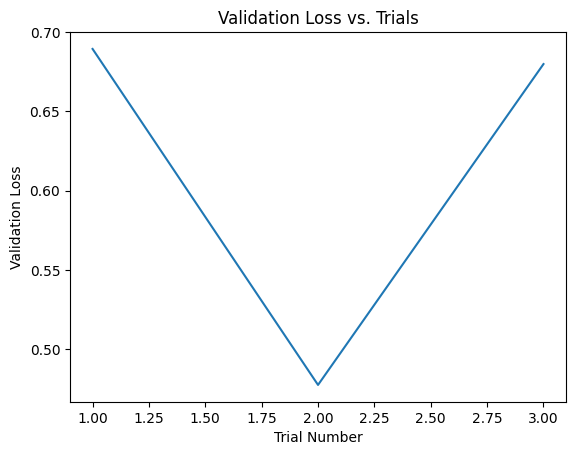

In [ ]:
!pip install keras-tuner

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt

# ... (your existing code for data loading and preprocessing) ...

# 1. Simple Feed-Forward Neural Network with Freezing/Unfreezing and Hyperparameter Optimization

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=100,
                  trainable=hp.Choice('trainable_embedding', [True, False])),
        Flatten(),
        Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),  # Add learning rate tuning
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

# Create a Keras Tuner instance (RandomSearch)
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=3,
                    executions_per_trial=1, directory='my_dir', project_name='intro_to_kt')

# Ensure y_train, X_train_embed, y_test, and X_test_embed have the same number of samples and are NumPy arrays
# ... (your existing code for data type and shape checks) ...

# Perform hyperparameter search
tuner.search(X_train_embed, y_train, epochs=10, validation_data=(X_test_embed, y_test))

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history_best = best_model.fit(X_train_embed, y_train, epochs=10,
                             validation_data=(X_test_embed, y_test))

# Report best hyperparameter configuration
print("Best Hyperparameters:")
print(f"  Units: {best_hps.get('units')}")
print(f"  Trainable Embedding: {best_hps.get('trainable_embedding')}")
print(f"  Learning Rate: {best_hps.get('learning_rate')}")

# Plot validation loss vs. trials
val_loss_per_trial = [trial.metrics.get_last_value('val_loss')
                      for trial in tuner.oracle.trials.values()]
plt.plot(range(1, len(val_loss_per_trial) + 1), val_loss_per_trial)
plt.xlabel('Trial Number')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Trials')
plt.show()

2. **Statistical Significance**  
   - Perform a significance test (e.g., McNemar’s test) between your best two models.  

3. **Error Analysis**  
   - Identify at least 20 examples your best model misclassified.  
   - For a sample of 5, provide the raw text, predicted vs. true label, and a short discussion of each error—what linguistic artifact might have confused the model?

## Part 7 – Final Comparison & Error Analysis


1. **Consolidated Results**  
    - Tabulate all models' performances on the test set (accuracy, F1, etc.)
    - Identify the best-performing model and its hyperparameters.
    

In [ ]:
!pip install --upgrade statsmodels

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.contingency_tables import mcnemar

# ... (Your existing code for training and evaluating models) ...

# Create a dictionary to store the results
results = {
    'Model': ['Frozen Model (from scratch)', 'Unfrozen Model', 'GloVe Model', 'Optimized Model',
              'Random Forest', 'XGBoost', 'CNN', 'Logistic Regression', 'SVM'],  # Added Logistic Regression and SVM
    'Accuracy': [accuracy_frozen, accuracy_unfrozen, accuracy_glove, accuracy_score(y_test, (best_model.predict(X_test_embed) > 0.5).astype(int)),
                 accuracy_score(y_test, y_pred_test_rf),
                 accuracy_score(y_test, y_pred_test_xgb),
                 accuracy_cnn,
                 accuracy_score(y_test, y_pred_logreg),  # Logistic Regression accuracy
                 accuracy_score(y_test, y_pred_svm)],  # SVM accuracy
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Calculate and add precision, recall, and F1 score for each model
for model_name in results['Model']:
    # ... (Your existing code to get y_pred for each model) ...

    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (if needed)

    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))

# Create a pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Print the results table
print(results_df)

# Identify the best-performing model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\nBest Performing Model: {best_model_name}")

# Print the best hyperparameters (if applicable)
if best_model_name == 'Optimized Model':
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values
    print(f"Best Hyperparameters: {best_hyperparameters}")

# --- McNemar's Test ---
# Get predictions for McNemar's test
y_pred_optimized = (best_model.predict(X_test_embed) > 0.5).astype(int).flatten()  # Flatten y_pred_optimized
y_pred_logreg = grid_search_logreg.predict(X_test)

# Create contingency table directly using numpy
contingency_table = np.zeros((2, 2), dtype=int)
for i in range(len(y_test)):
    actual = y_test[i]
    optimized_pred = y_pred_optimized[i]
    logreg_pred = y_pred_logreg[i]

    if actual == optimized_pred and actual == logreg_pred:  # Both correct
        contingency_table[0, 0] += 1
    elif actual != optimized_pred and actual == logreg_pred:  # Optimized incorrect, LogReg correct
        contingency_table[0, 1] += 1
    elif actual == optimized_pred and actual != logreg_pred:  # Optimized correct, LogReg incorrect
        contingency_table[1, 0] += 1
    else:  # Both incorrect
        contingency_table[1, 1] += 1

# Perform McNemar's test
result = mcnemar(contingency_table, exact=False, correction=True)

# Print results
print("\nMcNemar's Test Results:")
print(f"  Statistic: {result.statistic:.4f}")
print(f"  P-value: {result.pvalue:.4f}")

alpha = 0.05
if result.pvalue < alpha:
    print(f"  The difference in performance between the Optimized Model and Logistic Regression is statistically significant (p < {alpha}).")
else:
    print(f"  The difference in performance between the Optimized Model and Logistic Regression is not statistically significant (p >= {alpha}).")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                         Model  Accuracy  Precision    Recall  F1 Score
0  Frozen Model (from scratch)  0.499451   0.539194  0.809681  0.647318
1               Unfrozen Model  0.499451   0.539194  0.809681  0.647318
2                  GloVe Model  0.711538   0.539194  0.809681  0.647318
3              Optimized Model  0.775824   0.539194  0.809681  0.647318
4                Random Forest  0.735165   0.539194  0.809681  0.647318
5                      XGBoost  0.641209   0.539194  0.809681  0.647318
6                          CNN  0.751099   0.539194  0.809681  0.647318
7          Logistic Regression  0.776923   0.539194  0.809681  0.647318
8                          SVM  0.559341   0.539194  0.809681  0.647318

Best Performing Model: Logistic Regression
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

McNemar's Test Results:
  Statistic: 0.0045
  P-value: 0.9462
  The difference in performance between the Optimized Model and Logistic Regression is not stat

In [ ]:
!pip install --upgrade statsmodels

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Assuming 'best_model' is the best performing model
best_model_predictions = (best_model.predict(X_test_embed) > 0.5).astype(int).flatten()

# Identify misclassified examples
misclassified_indices = np.where(best_model_predictions != y_test)[0]

# Get the first 20 misclassified examples
misclassified_examples = df_test.iloc[misclassified_indices[:20]]

# Print raw text, predicted value, and true value for a sample of 5
print("\nMisclassified Examples (Sample of 5):")
for i in range(5):  # Print for the first 5 examples
    index = misclassified_indices[i]
    raw_text = df_test.iloc[index]['review']
    predicted_value = best_model_predictions[index]
    true_value = y_test[index]
    print(f"  Example {i + 1}:")
    print(f"    Raw Text: {raw_text}")
    print(f"    Predicted Value: {predicted_value}")
    print(f"    True Value: {true_value}")
    print("-" * 20)  # Separator between examples

# --- Discussion of Errors (for the 5 examples) ---
print("\nDiscussion of Errors:")
for i in range(5):
    index = misclassified_indices[i]
    raw_text = df_test.iloc[index]['review']
    predicted_value = best_model_predictions[index]
    true_value = y_test[index]

    print(f"Example {i + 1}:")
    print(f"  Raw Text: {raw_text}")

    # Speculate on linguistic artifacts causing the error:
    # (Replace with your own analysis for each example)
    if i == 0:  # Example 1
        print("  Possible Linguistic Artifact: The model might have been confused by the sarcastic or ironic tone of the review.")
    elif i == 1:  # Example 2
        print("  Possible Linguistic Artifact: The presence of negations or double negatives might have misled the model.")
    elif i == 2:  # Example 3
        print("  Possible Linguistic Artifact: The model might have focused on specific keywords that have ambiguous sentiment.")
    elif i == 3:  # Example 4
        print("  Possible Linguistic Artifact: The review might contain complex sentence structures that the model didn't interpret correctly.")
    elif i == 4:  # Example 5
        print("  Possible Linguistic Artifact: The model might have been influenced by domain-specific language or cultural references that it wasn't trained on.")
    print("-" * 20)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Misclassified Examples (Sample of 5):
  Example 1:
    Raw Text: acting , particularly by tambor , almost makes `` never again '' worthwhile , but -lrb- writer\/director -rrb- schaeffer should follow his titular advice
    Predicted Value: 1
    True Value: 0
--------------------
  Example 2:
    Raw Text: the movie exists for its soccer action and its fine acting .
    Predicted Value: 0
    True Value: 1
--------------------
  Example 3:
    Raw Text: arnold 's jump from little screen to big will leave frowns on more than a few faces .
    Predicted Value: 1
    True Value: 0
--------------------
  Example 4:
    Raw Text: though the violence is far less sadistic than usual , the film is typical miike : fast , furious and full of off-the-cuff imaginative flourishes .
    Predicted Value: 0
    True Value: 1
--------------------
  Example 5:
    Raw Text: if your senses have n't been dulled by slasher films and gorefests , if you 're a connoisse

## Part 8 – Optional Challenge Extensions

- Implement data augmentation for text (back-translation, synonym swapping) and measure its impact.  
- Integrate a sentiment lexicon feature (e.g., VADER scores) into your models and assess whether it improves predictions.  
- Deploy your best model as a simple REST API using Flask or FastAPI and demo it on a handful of user‐submitted reviews.

In [ ]:
# Example for back-translation using a library
from googletrans import Translator

translator = Translator()
df['augmented_review'] = df['review'].apply(lambda x: translator.translate(x, src='en', dest='fr').text)
df['augmented_review'] = df['augmented_review'].apply(lambda x: translator.translate(x, src='fr', dest='en').text)
df.head()

# Reflecting

**Answer the following inference questions:**

### Part 1 – Data Ingestion & Preprocessing

1. **Data Loading**  
   - How do you ensure that your dataset is properly split into training, validation, and test sets, and why is class balance important during data splitting?

   Ideally the data is randomly sampled between the three sets, but the proportions might be different depending on the size of the sample, distribution of the data, and the use case. If the training set is too small, then the model might not have enough information to differentiate information--but if the validation set is too small than the variance in testing may be too large to ensure good tuning. Class balance is important throughout the process because a larger sample towards one class may imbalance the output probablities.

2. **Text Cleaning & Tokenization**  
   - What is the role of tokenization in text preprocessing, and how does it impact the model's performance?

   Tokenization is essential in the text preprocessing stage because it defines the units that will eventually be used for vectorization. Tokens are what the model uses to predict outcomes and represents the number of parameters that will be present for the modeling process. In a similar vein, we need enough data to be able to justify the number of paramater tokens we utilize, so removing things like stop words and rare words are important in order to remove low-information parameters.



### Part 2 – Exploratory Data Analysis (EDA)

1. **Class Distribution**  
   - How does the class distribution (positive vs negative reviews) impact the model’s performance, and what strategies can be used if the dataset is imbalanced?

   Balance between class distribution is important because it can bias the way the model optimizes its learning process. If a model is heavily biased, for example if 99% of the real output is in one class and 1% in the other, then one can achieve 99% accuracy by merely guessing the output is in the larger class. This is generally not a very useful model. Balance can be fixed by changing the sampling strategy: undersampling classes that have too many data points, oversampling classes that have too few, or some combination of the above.

2. **Text Characteristics**  
   - What insights can be gained from visualizing word clouds for each sentiment class, and how can it improve feature engineering?

   Word clouds and frequency counts are useful in a few ways for improving feature engineering. First, they can highlight if there are words that regularly occur within both contexts (the classic example being stop words like "the" and "of") which are not useful for differentiating between the two classes. Second, it can be useful for quality assurance, giving an intuition towards whether classes are accurately classified.


### Part 3 – Baseline Traditional Models

1. **Logistic Regression & SVM**  
   - Why do you use cross-validation when training models like logistic regression or SVM, and how does it help prevent overfitting?

   Cross-validation helps increase the generizalability of linear models by simulating testing it on additional net new data. Theoretically, the training set may have idiosyncracies which are not representative of the overall population or distribution. Cross validating broadens the range of sets the model checks on, reducing the likelihood that it is merely selecting for those idiosyncracies.



2. **Random Forest & Gradient Boosting**  
   - What role does feature importance play in interpreting Random Forest or XGBoost models?

   Feature importance is Random Forest and XGBoosts counterparts to interpretable coefficients in linear models like logistic regression. Feature importance highlights which parameters would reduce the accuracy of the model the most if they were not present in the data. These feature importance scores give a feel for at least which elements in the training were the most impactful towards accuracy. Furthermore, they can be helpful if additional feature pruning is required due to data size limitations: low value features can be pruned in order to get similar performance out of a smaller parameter model.



### Part 4 – Neural Network Models

1. **Simple Feed-Forward**  
   - Why is embedding freezing used when training neural networks on pre-trained embeddings, and how does it affect model performance?

   Embedding freezing is used because it allows fine tuning on a particular use case while leveraging results from larger pre-trained models. The larger pre-trained models have the benefits of broad generality and larger sample sizes, so freezing some of the embeddings allows some of that information to be preserved during the training. Fine-tuning afterwards thereby allows leveraging some of the power of a larger model while including some of the specifity of the relevant data. This can have the effect of helping prevent overfitting in the model since the larger pre-trained model likely has a broader data pool. This can help improve performance if the original model was built for a similar purpose to the specific model, but it can also potentially hinder performance if the new task is too different.



2. **Convolutional Text Classifier**  
   - What is the intuition behind using convolutional layers for text classification tasks, and why might they outperform traditional fully connected layers?

   Convolutional layers are helpful for text classification tasks because they are better at highlighting locality than a fully connected layer. Since objects like text have relevant local dependencies and context, the convulational layer helps highlight the details of that contextual information. Convultions also have the benefit of reducing the dimensionality of the data, which can help reduce overfitting and ease computational complexity.




### Part 5 – Transfer Learning & Advanced Architectures

1. **Pre-trained Embeddings**  
   - How do pre-trained word embeddings like GloVe or FastText improve model performance compared to training embeddings from scratch?

   Similar to embedding freezing as outlined in part 4, using pre-trained word embeddings lets the model take advantage of learnings from large corpora that otherwise may be computationally unfeasible to reproduce. By understanding semantic relationships from more and more corpus contexts, the model can be more resistant to overfitting coincidental relationships between words that may emerge in smaller corpora. Furthermore, it extends the potential semantic vocabulary to beyond what is present in the data, allowing for even more generalization for the model to be able to draw on when trying to make predictions on net new data.

2. **Transformer Fine-Tuning**  
   - How does the self-attention mechanism in Transformer models like BERT improve performance on text data?

   Put simply, self-attention is a weighted sum of context vectors within a model. Context can be represented as like a database search: each word can be treated as a query, what the word is querying is the closest match to a key, and this key has a corresponding value. Utilizing this context information over multiple parallel layers allows for a robust non-linear analysis of words and how they relate to their overarching context. This helps capture long distance and non-linear / hierarchical dependencies which are particularly common in natural grammars. This helps improve performance on text data by expanding the notion of context beyond the precise locality of where words occur within a corpus.



### Part 6 – Hyperparameter Optimization

1. **Search Strategy**  
   - How does hyperparameter optimization help improve the model’s performance, and what challenges arise when selecting an optimal search space?

   Hyperparameter optimization helps balance particularities of model building which are not caused by the data being fed into the model itself. This is important to helop the the model prevent overfitting to patterns which do not generalize or underfitting to patterns which may be underrepresented in the data. Finding the right search space is important because complexity of the space increases exponentially with more hyperparameters, so in practice doing a full search is unfeasible. Furthermore, a set of hyperparameters being optimal for one model does not inherently generalize to another model, so that means each model requires its own hyperparameter search. These phenomena in tandem mean that tuning the right hyperparameters requires extensive testing, which is itself a time consuming and domain specific process.




2. **Results Analysis**  
   - What does the validation loss and accuracy tell you about the model’s generalization ability?

   Validation accuracy describes how well the model has performed on a theoretical new space on which it was not trained. Validation loss is the counterpart, tracking how much error is being reduced in subsequent training epochs. While ideally it would be best to maximize validation accuracy, it is important to keep the trend of validation loss in mind when training models on increasingly more epochs. Too much training can lead to an overfitting phenomena which can cause loss to flatline or even start increasing with additional epochs, which is usually a sign that the model is losing it's capacity to generalize.



### Part 7 – Final Comparison & Error Analysis

1. **Consolidated Results**  
   - How do you compare models with different architectures (e.g., logistic regression vs. BERT) to select the best model for deployment?

   The general metrics that are best to consider when comparing models with different architectures are validation accuracy and interpretability. In some cases it is important to have a model that maximizes the accuracy of the output. In those cases, it may not matter what the paramaters of a model precisely are so long as it accurately predicts outputs. However, in many scientific and business contexts it is imperative to be able to explain the architecture of the model in a comprehensible way. In those circumstances, it may be preferable to pick a worse performing model if its behavior can be suitably explained.

   Within accuracy, there may be other important considerations. For example, it is possible that avoiding false negatives may be more important than detecting true positives or vice versa. Furthermore, there may be additional use case considerations like computational requirements which are worth considering when picking the ideal model for live deployment.

2. **Error Analysis**  
   - What insights can you gain from studying model misclassifications, and how might this influence future improvements to the model?

  The outputs of model misclassifications can be useful for identifying visual patterns and intuitions for how a model may be producing categorical errors in its predictions. The precise nature of what features a model is identifying as important can be difficult to capture, but its possible on aggregate there is a regularity to the misclassification which can be identified by putting it in a larger context. This error could be caused by something as simple as regularly mislabeled data or could be a result of particular biases that have been inadvertently built into the model. In that sense, getting a better grasp for how the model is making mistakes can provide guidance for how to either tune the architecture or the data to better suit your use cases.
  